# Retraining LSTM Model based on K-Fold Cross Validation findings

In [60]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import pickle
from keras.models import load_model
import h5py
from matplotlib.dates import date2num 
from mpl_finance import candlestick_ohlc
import matplotlib
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization


In [61]:
start='2014-04-01'
end='2019-09-18'
window = 7
predictedDays = 220
targetColumn = 3


In [62]:
tickers = ['SPY',
               'XLF', # Financials
                'EEM', # Emerging Markets
                'XRT', # S&P Retail
                'FXI' ,# China Large Cap
                'XHB', # S&P Homebuilders (Tracks real estate)
                'TLT', # 20 yr Treasury Bond
                'USO', # US Oil Fund
                'DBC', # Commodity Tracking
                'GLD', # Gold
                'QQQ',
                'DXJ', #Japan
          ]


In [63]:
df1=pd.DataFrame()
for tic in tickers:
    data=web.DataReader(tic,'yahoo',start,end )
    data=data.drop(columns=['Adj Close'])
    cols=[]
    for col in data.columns:
        cols.append(str(col)+'_'+str(tic))
    data.columns=cols
    df1=pd.concat([df1,data],axis=1)
df1.head()


,High_SPY,Low_SPY,Open_SPY,Close_SPY,Volume_SPY,High_XLF,Low_XLF,Open_XLF,Close_XLF,Volume_XLF,...,High_QQQ,Low_QQQ,Open_QQQ,Close_QQQ,Volume_QQQ,High_DXJ,Low_DXJ,Open_DXJ,Close_DXJ,Volume_DXJ
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-01,188.360001,187.000000,187.619995,188.250000,89193000.0,18.237206,18.131599,18.196589,18.180342,51651700.0,...,89.269997,87.709999,88.099998,89.209999,38683800.0,47.709999,47.389999,47.470001,47.689999,5555800.0
2014-04-02,189.130005,188.139999,188.490005,188.880005,78774000.0,18.261576,18.164095,18.196589,18.220959,44565200.0,...,89.680000,89.040001,89.589996,89.440002,34631600.0,48.150002,47.730000,47.770000,48.130001,4685900.0
2014-04-03,189.220001,188.050003,189.169998,188.630005,77435000.0,18.261576,18.131599,18.237206,18.188465,46626800.0,...,89.680000,88.220001,89.529999,88.730003,30319100.0,48.150002,47.830002,48.070000,47.990002,2358800.0
2014-04-04,189.699997,186.100006,189.660004,186.399994,169381000.0,18.326563,17.993502,18.285946,18.009748,60202300.0,...,89.410004,86.139999,89.320000,86.370003,131213200.0,48.139999,47.250000,48.090000,47.439999,4170300.0
2014-04-07,186.259995,183.960007,185.949997,184.339996,140803000.0,18.001625,17.717302,17.993502,17.733549,72897100.0,...,86.629997,84.949997,85.830002,85.550003,83995800.0,47.380001,47.020000,47.250000,47.080002,3274800.0


In [64]:
df1['ma7'] = df1['Close_SPY'].rolling(window=7).mean()
df1['ma21'] = df1['Close_SPY'].rolling(window=21).mean()

exp1 = df1.Close_SPY.ewm(span=12, adjust=False).mean()
exp2 = df1.Close_SPY.ewm(span=26, adjust=False).mean()
df1['MACD'] = exp1-exp2

df1=df1.dropna()


In [65]:
target=pd.DataFrame(df1[df1.columns[targetColumn]])
target.columns=(['Closing_price'])
target.head()


,Closing_price
Date,
2014-04-30,188.309998
2014-05-01,188.330002
2014-05-02,188.059998
2014-05-05,188.419998
2014-05-06,186.779999


In [66]:
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(np.array(target['Closing_price']).reshape(-1,1))
scaled_target= target_scaler.transform(np.array(target['Closing_price']).reshape(-1,1))
scaled_target=[scaled_target[i][0] for i in range(len(scaled_target))]


In [67]:
with open('scalers/target_scaler.pickle', 'wb') as t:
        pickle.dump(target_scaler, t, protocol=pickle.HIGHEST_PROTOCOL)


In [68]:
df=df1.copy()
df=pd.concat([df])
df.head()


,High_SPY,Low_SPY,Open_SPY,Close_SPY,Volume_SPY,High_XLF,Low_XLF,Open_XLF,Close_XLF,Volume_XLF,...,Close_QQQ,Volume_QQQ,High_DXJ,Low_DXJ,Open_DXJ,Close_DXJ,Volume_DXJ,ma7,ma21,MACD
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-30,188.500000,187.179993,187.440002,188.309998,101508000.0,17.879772,17.749798,17.766045,17.839155,46774300.0,...,87.389999,38689400.0,46.110001,45.779999,45.849998,46.090000,5004300.0,187.485713,186.307619,0.082466
2014-05-01,188.839996,187.729996,188.220001,188.330002,93019000.0,17.896019,17.782291,17.839155,17.871649,33615500.0,...,87.650002,37127200.0,46.549999,46.330002,46.439999,46.430000,3558900.0,187.548571,186.311428,0.185327
2014-05-02,189.139999,187.779999,188.309998,188.059998,98122000.0,18.025995,17.822908,17.879772,17.863525,34600200.0,...,87.489998,40074200.0,46.970001,46.230000,46.790001,46.380001,4895500.0,187.635714,186.272380,0.242266
2014-05-05,188.550003,186.619995,187.139999,188.419998,75883000.0,17.806662,17.636068,17.701056,17.790415,23206100.0,...,87.949997,27924400.0,46.279999,45.889999,46.000000,46.209999,2493000.0,187.719999,186.262380,0.312833
2014-05-06,188.130005,186.740005,188.000000,186.779999,85454000.0,17.741673,17.538586,17.741673,17.538586,73906200.0,...,86.809998,33698500.0,45.930000,45.689999,45.889999,45.840000,2649300.0,187.790000,186.280475,0.233730


In [69]:
#Scalling all columns
#------------------------------------------------------------------------------------------------------------------------
scalers=[]
for col in df.columns:
    name = 'scaler_'+str(col)
    scaler = MinMaxScaler(feature_range=(0, 1))
    s= scaler.fit_transform(np.array(df[col]).reshape(-1,1))
    s= [s[i][0] for i in range(len(s))]
    df[col]=s
    scalers.append(scaler)
    with open('scalers/'+name+'.pickle', 'wb') as t:
        pickle.dump(scaler, t, protocol=pickle.HIGHEST_PROTOCOL)
    
df.head()


,High_SPY,Low_SPY,Open_SPY,Close_SPY,Volume_SPY,High_XLF,Low_XLF,Open_XLF,Close_XLF,Volume_XLF,...,Close_QQQ,Volume_QQQ,High_DXJ,Low_DXJ,Open_DXJ,Close_DXJ,Volume_DXJ,ma7,ma21,MACD
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-30,0.037121,0.051406,0.042664,0.045741,0.153637,0.122019,0.180518,0.122246,0.131584,0.143273,...,0.008363,0.219895,0.336385,0.346841,0.342482,0.340510,0.170521,0.011289,0.000401,0.629084
2014-05-01,0.039990,0.055996,0.049189,0.045909,0.135929,0.123165,0.182686,0.127411,0.133873,0.092529,...,0.010753,0.209028,0.353901,0.368693,0.365951,0.354067,0.117794,0.011837,0.000435,0.637320
2014-05-02,0.042521,0.056413,0.049941,0.043642,0.146573,0.132331,0.185397,0.130281,0.133301,0.096326,...,0.009282,0.229529,0.370621,0.364720,0.379873,0.352073,0.166552,0.012597,0.000089,0.641880
2014-05-05,0.037543,0.046733,0.040154,0.046664,0.100183,0.116864,0.172929,0.117654,0.128152,0.052387,...,0.013510,0.145009,0.343153,0.351212,0.348449,0.345295,0.078911,0.013332,0.000000,0.647530
2014-05-06,0.034000,0.047734,0.047348,0.032900,0.120148,0.112281,0.166423,0.120524,0.110416,0.247902,...,0.003033,0.185176,0.329220,0.343266,0.344073,0.330542,0.084613,0.013943,0.000160,0.641196


In [70]:
#PCA
#-----------------------------------------------------------------------------------------------------------------------
pca = PCA(n_components=15)
df = pd.DataFrame(pca.fit_transform(df), index = df.index)
with open('scalers/pca.pickle', 'wb') as t:
        pickle.dump(pca, t, protocol=pickle.HIGHEST_PROTOCOL)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Date,,,,,,,,,,,,,,,
2014-04-30,-1.979828,-1.292657,1.125212,0.421952,-0.024140,-0.178520,0.097343,0.198035,-0.185335,0.081580,-0.001064,0.010159,0.027331,-0.052628,-0.068913
2014-05-01,-1.946179,-1.298152,1.075969,0.380715,-0.010905,-0.231043,0.116606,0.150949,-0.134150,0.127019,0.022832,0.049453,0.053529,0.032474,-0.139203
2014-05-02,-1.925431,-1.300790,1.081339,0.346519,-0.060511,-0.107250,0.177743,0.191731,-0.213783,0.054587,0.015191,0.035789,0.026529,0.052613,-0.080208
2014-05-05,-1.952892,-1.279052,1.151487,0.290108,-0.063942,-0.279880,0.076785,0.126449,-0.216346,0.137988,-0.018624,0.023217,0.110800,0.092521,0.018899
2014-05-06,-1.980024,-1.271593,1.193897,0.387539,-0.052018,-0.090274,0.089080,0.164020,-0.091820,0.127479,-0.127525,-0.022543,0.185842,0.306169,0.126746


In [71]:
#splitting to train and test
#------------------------------------------------------------------------------------------------------------------------
data=df.copy()# making a copy in case we need to get back to original data
array_data=data.values
len_train=int(len(array_data)-predictedDays)
train=array_data[:len_train]
scaled_target_train=scaled_target[:len_train]
test=array_data[len_train:]
scaled_target_test=scaled_target[len_train:]


In [72]:
#Train Set
#---------------------------------------------------------------------------------------------------------------------------
x_train, y_train = [],[]
for i in range(window+1,len(train)):
    x_train.append(train[i-(window+1):i-1])
    y_train.append(scaled_target_train[i])
    
x_train, y_train=np.array(x_train), np.array(y_train)


In [73]:
#Test Set
#-----------------------------------------------------------------------------------------------------------------
x_test, y_test = [],[]
for i in range(window+1,len(test)):
    x_test.append(test[i-(window+1):i-1])
    y_test.append(scaled_target_test[i])
    
x_test, y_test=np.array(x_test), np.array(y_test)


In [74]:
model = Sequential()
model.add(LSTM(units=100,return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(LSTM(units=100))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 7, 100)            46400     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 126,901
Trainable params: 126,901
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.fit(x_train, y_train, epochs=4, batch_size=1, verbose=1)

Epoch 1/4
1130/1130 [==============================] - 17s 15ms/step - loss: 0.0051
Epoch 2/4
1130/1130 [==============================] - 15s 14ms/step - loss: 0.0013
Epoch 3/4
1130/1130 [==============================] - 15s 13ms/step - loss: 0.0012
Epoch 4/4
1130/1130 [==============================] - 15s 13ms/step - loss: 0.0011


In [76]:
closing_price = model.predict(x_test)
closing_price = target_scaler.inverse_transform(closing_price)


In [77]:
model.save('scalers/model.h5')
predsData=pd.DataFrame(index =target.index[-len(x_test):] )
predsData['preds']=closing_price


In [78]:
y_test=target_scaler.inverse_transform(y_test.reshape(-1,1))
rms=np.sqrt(np.mean(np.power((y_test-closing_price),2)))
print('The Root Mean Squared error is :',rms)


The Root Mean Squared error is : 11.118405680763454


In [97]:
#closing_price=[closing_price[i][0] for i in range(len(closing_price)) ]
o= df1['Open_SPY'][-len(closing_price):]
l=df1['Low_SPY'][-len(closing_price):]
c=df1['Close_SPY'][-len(closing_price):]
p=closing_price
diff= [c[i]-p[i] for i in range(len(p))]
pa=[p[0]]+[p[i+1]+diff[i]*0.8 for i in range(0, len(p)-1)]


In [98]:
from math import trunc 
def trc(x,power):
    return trunc(x*10**power)/(10**power)


In [99]:
date = df1.index[-len(closing_price):]

points,returns,market=[],[],[]
invest, market,count =1,1,0
portfolioPerf, marketPerf = [],[]
for i in range(len(p)):

#Trading days
#-----------------------------------------------------------------------------------------------------------------------
    if l[i]<pa[i]: # Orders are placed at predicted price, if the low is lower than our prediction we get filled 
        
        if pa[i]>o[i]: 
            buy=o[i]#if market opens lower than our limit price we get fileld at open price
        else:
            buy=pa[i]#if market opens higher than our limit price we get fileld at perdicted price
        
        points.append([date[i],l[i]])
        sell=c[i]#We are always selling at closing price
        returns=(sell-buy)/buy
        invest = invest * (1+returns)
        portfolioPerf.append(invest)
        count +=1
        
        #print('On',str(date[i])[:10],' we bought at',trc(buy,2),' and sold at',trc(sell,2),'for a return of',trc(returns,4)*100,'%. Open was', trc(o[i],2),'and close was',trc(c[i],2))
        
    else: #if the low of the day is higher than our predicted price we never got filled
        portfolioPerf.append(invest)
        
        
    if i == 0:
        market = market*(1+(c[i]-o[i])/o[i])
    else:
        market = market*(1+(c[i]-c[i-1])/c[i-1])
    marketPerf.append(market)

print('\nWe traded',count, 'days out of',len(c),'days.')
#print('\nModel Portfolio :',trc(invest,3),'Market Portfolio ', trc(market,3))



We traded 75 days out of 212 days.


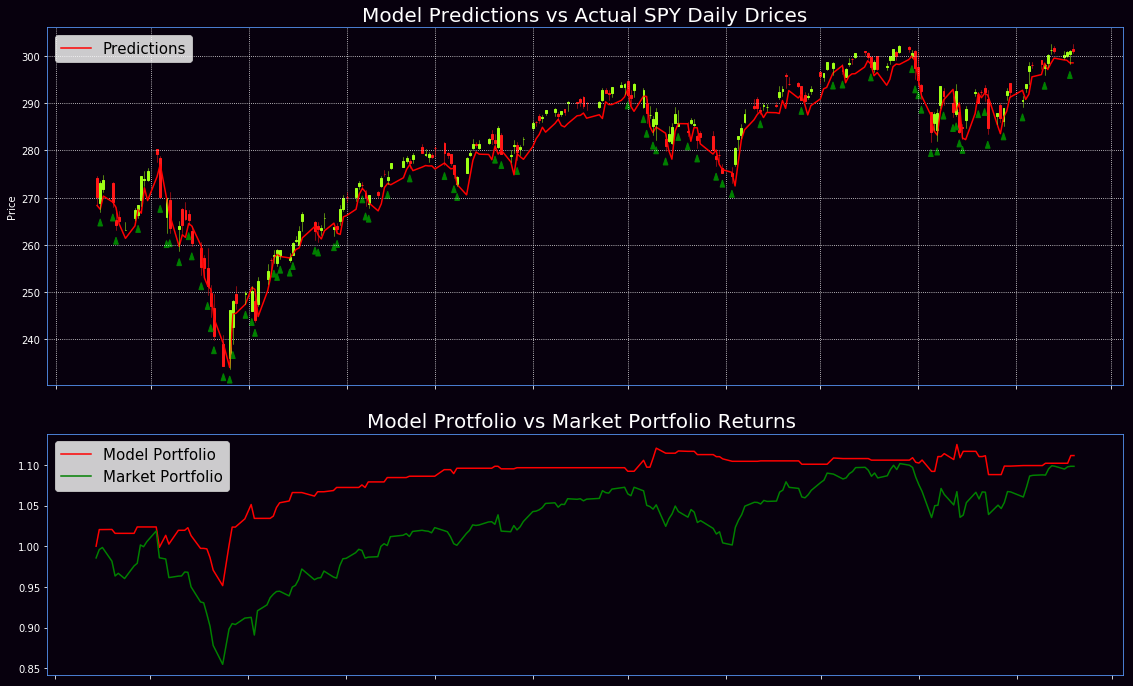

In [100]:
closep, highp, lowp, openp = c, df1['High_SPY'][-len(closing_price):],l, o
date=[date2num(i) for i in date]
candleAr = [tuple([date[i],
                openp[i],
                highp[i],
                lowp[i],
                closep[i]]) for i in range(len(date))] #_1
date=df1.index[-len(closing_price):]
    
    
fig = plt.figure(figsize=(18,12), facecolor='#07000D')#
ax = plt.subplot2grid((12,4),(0,0), rowspan = 7, colspan = 4, facecolor='#07000D')
ax.grid(linestyle=':', color='w')
ax.yaxis.label.set_color('w')
ax.plot(date,pa,color='r', label = 'Predictions')
ax.spines['bottom'].set_color("#599Bff")
ax.spines['top'].set_color("#599Bff")
ax.spines['left'].set_color("#599Bff")
ax.spines['right'].set_color("#599Bff")
ax.tick_params(axis='y', colors='w')
ax.tick_params(axis='x', colors='w')
plt.ylabel('Price')
for point in points:
    ax.arrow(point[0], point[1]-3, 0, 1.5,color='g',shape='full',length_includes_head=True,head_width=1.5,head_length=1.5, label = 'Buy')
plt.legend(loc=2, prop={'size':15},fancybox=True)

fig.autofmt_xdate()
fig.tight_layout()

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))

candlestick_ohlc(ax, candleAr, colorup = '#9eff15', colordown='#ff1717', width=0.6);

ax2 = plt.subplot2grid((12,4),(7,0), rowspan = 5, colspan = 4, facecolor='#07000D')
ax2.grid(linestyle=':', color='w')
ax2.yaxis.label.set_color('w')
ax2.spines['bottom'].set_color("#599Bff")
ax2.spines['top'].set_color("#599Bff")
ax2.spines['left'].set_color("#599Bff")
ax2.spines['right'].set_color("#599Bff")
ax2.tick_params(axis='y', colors='w')
ax2.tick_params(axis='x', colors='w')
ax2.plot(date,portfolioPerf,color = 'r', label = 'Model Portfolio' )
ax2.plot(date,marketPerf,color = 'g', label = 'Market Portfolio')
plt.legend(loc=2, prop={'size':15},fancybox=True)
fig.autofmt_xdate()
fig.tight_layout()
ax2.grid(False)
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))

ax.set_title('Model Predictions vs Actual SPY Daily Drices', color='w', fontsize = 20)
ax2.set_title('Model Protfolio vs Market Portfolio Returns ', color='w', fontsize = 20);
plt.subplots_adjust(left = 0.10, bottom= 0.2, right = 0.93, top = 0.95, wspace = 0.20, hspace = 5.00)


# Saving Model and backtest data for live updating Notebook

In [102]:
marketPerf=marketPerf[:-1]
portfolioPerf=portfolioPerf[:-1]

In [103]:
Perf=pd.DataFrame(columns=['marketPerf','portfolioPerf'],index=date[:-1])
Perf['marketPerf']=marketPerf
Perf['portfolioPerf']=portfolioPerf
Perf.to_csv('scalers/Perf.csv')

In [104]:
adjPreds=pd.DataFrame(pa,columns=['pa'])
adjPreds.to_csv('scalers/adjPreds.csv',index=False)

In [105]:
predsData.to_csv('scalers/predsData.csv')

In [106]:
pointData=pd.DataFrame(points,columns=['Date','Buy']).set_index('Date')
pointData.to_csv('scalers/pointData.csv')

# Conclusion

-We were able to achieve better results thanks to findings from K-Fold Cross Validation.

-Backtest showed model slightly outperforms market returns over testing period.

# Next Steps

-Create web aplication to stream model performace.

-Write a Script to update the chart on website based on live stock prices and news.
